# Unsupervized Learning Trading Strategy for Portfolio Optimization

In [10]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from sklearn.cluster import KMeans

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.ticker as mtick
from dateutil.relativedelta import relativedelta

warnings.filterwarnings('ignore')

# Loading the dataset

In [11]:
sp500 = pd.read_parquet('stock_sample_data.parquet')
sp500['context_id'] = sp500['context_id'].str.replace('.', '-')

symbols_list = sp500['context_id'].unique().tolist()

display(sp500.head())

,date,open,high,low,close,volume,context_id,day
0,2000-01-03,56.330471,56.464592,48.193848,43.463036,4674353,A,0
1,2000-01-03,0.936384,1.004464,0.907924,0.844004,535796800,AAPL,0
2,2000-01-03,15.823756,16.160433,15.599306,8.327244,10635087,ABT,0
3,2000-01-03,1.409722,1.416667,1.263889,1.277778,433800,ACGL,0
4,2000-01-03,16.812500,16.875000,16.062500,16.274672,7384400,ADBE,0


In [12]:
end_date = '2024-10-01'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = pd.read_parquet('stock_sample_data.parquet')

df['date'] = pd.to_datetime(df['date'])

df = df.set_index(['date', 'context_id'])

df.columns = df.columns.str.lower()

display(df)

open        high         low       close  \
date       context_id                                                   
2000-01-03 A            56.330471   56.464592   48.193848   43.463036   
           AAPL          0.936384    1.004464    0.907924    0.844004   
           ABT          15.823756   16.160433   15.599306    8.327244   
           ACGL          1.409722    1.416667    1.263889    1.277778   
           ADBE         16.812500   16.875000   16.062500   16.274672   
...                           ...         ...         ...         ...   
2024-10-15 XYL         137.630005  138.469894  137.210007  137.785004   
           YUM         134.210007  134.669998  132.723999  133.779999   
           ZBH         103.510002  105.970001  103.785004  105.294998   
           ZBRA        376.739990  380.034393  374.040009  374.859985   
           ZTS         192.279999  195.809998  192.184998  193.877594   

                          volume  day  
date       context_id                  
2000-01-03 A             4674353    0  
           AAPL        535796800    0  
           ABT          10635087    0  
           ACGL           433800    0  
           ADBE          7384400    0  
...                          ...  ...  
2024-10-15 XYL            347338    1  
           YUM            513843    1  
           ZBH            436167    1  
           ZBRA           143956    1  
           ZTS            505126    1  

[2770140 rows x 6 columns]

# Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [13]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

df['dollar_volume'] = (df['close']*df['volume'])/1e6

display(df.head())



open       high        low      close     volume  \
date       context_id                                                          
2000-01-03 A           56.330471  56.464592  48.193848  43.463036    4674353   
           AAPL         0.936384   1.004464   0.907924   0.844004  535796800   
           ABT         15.823756  16.160433  15.599306   8.327244   10635087   
           ACGL         1.409722   1.416667   1.263889   1.277778     433800   
           ADBE        16.812500  16.875000  16.062500  16.274672    7384400   

                       day  garman_klass_vol  rsi  bb_low  bb_mid  bb_high  \
date       context_id                                                        
2000-01-03 A             0         -0.013436  NaN     NaN     NaN      NaN   
           AAPL          0          0.000938  NaN     NaN     NaN      NaN   
           ABT           0         -0.158582  NaN     NaN     NaN      NaN   
           ACGL          0          0.002781  NaN     NaN     NaN      NaN   
           ADBE          0          0.000809  NaN     NaN     NaN      NaN   

                       atr  macd  dollar_volume  
date       context_id                            
2000-01-03 A           NaN   NaN     203.161571  
           AAPL        NaN   NaN     452.214661  
           ABT         NaN   NaN      88.560962  
           ACGL        NaN   NaN       0.554300  
           ADBE        NaN   NaN     120.178685

## Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [14]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'day']]

data = (pd.concat([df.unstack('context_id')['dollar_volume'].resample('M').mean().stack('context_id').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('context_id')],
                  axis=1)).dropna()

display(data.head())

dollar_volume      close  garman_klass_vol        rsi  \
date       context_id                                                          
2000-02-29 A               88.145907  62.704441         -0.006802  68.722933   
           AAPL           308.151400   0.864268         -0.009023  53.657093   
           ABT             73.891687   7.889996         -0.154744  47.943441   
           ACGL             0.314569   1.694444          0.001015  59.366499   
           ADBE           210.337227  25.319607          0.000673  68.553975   

                         bb_low    bb_mid   bb_high       atr      macd  
date       context_id                                                    
2000-02-29 A           3.700766  3.964441  4.228116  5.556953  4.213603  
           AAPL        0.567111  0.610482  0.653853 -1.158474 -0.176111  
           ABT         2.143018  2.203045  2.263071 -0.002152 -0.221243  
           ACGL        0.922973  0.954054  0.985135 -0.732163 -0.202365  
           ADBE        2.791578  3.121100  3.450623 -0.470966  0.336995

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [15]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('context_id').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

display(data.head())  

close  garman_klass_vol        rsi    bb_low  \
date       context_id                                                     
2001-01-31 A           32.929268         -0.011220  48.247056  3.444129   
           AAPL         0.326103         -0.009124  62.246634  0.203225   
           ABT         10.917043         -0.144972  45.631811  2.408823   
           ADBE        21.707405          0.007695  38.292843  3.141967   
           ADI         39.168118         -0.069116  57.877089  3.388347   

                         bb_mid   bb_high       atr      macd  
date       context_id                                          
2001-01-31 A           3.577412  3.710694  2.303712  0.028144  
           AAPL        0.247146  0.291066 -1.234586 -0.176379  
           ABT         2.463091  2.517359  1.453425 -0.382311  
           ADBE        3.314002  3.486037 -0.256864 -0.317608  
           ADI         3.549417  3.710487  2.226095  0.516065

## Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [16]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

display(data.head())  

close  garman_klass_vol        rsi    bb_low  \
date       context_id                                                     
2002-01-31 A           18.320875         -0.006149  55.598069  2.854033   
           AAPL         0.372776         -0.007926  63.304255  0.268863   
           ABT         14.275370         -0.128915  61.997635  2.671156   
           ADBE        16.771486          0.000185  49.120168  2.861406   
           ADI         27.405174         -0.084558  49.626947  3.268712   

                         bb_mid   bb_high       atr      macd  return_1m  \
date       context_id                                                      
2002-01-31 A           2.954090  3.054146 -0.009183 -0.046081   0.064539   
           AAPL        0.292884  0.316905 -1.229868 -0.184167   0.128769   
           ABT         2.703496  2.735837  2.463956  0.025361   0.038927   
           ADBE        2.921234  2.981063 -0.615679 -0.082874   0.085346   
           ADI         3.359408  3.450104  1.193607 -0.374254  -0.013291   

                       return_2m  return_3m  return_6m  return_9m  return_12m  
date       context_id                                                          
2002-01-31 A            0.054962   0.108697   0.009889  -0.027506   -0.047686  
           AAPL         0.077295   0.120749   0.046776  -0.003402    0.011209  
           ABT          0.026204   0.030163   0.013710   0.025947    0.022603  
           ADBE         0.025145   0.084927  -0.017458  -0.031299   -0.021268  
           ADI          0.015179   0.048488  -0.008135  -0.008529   -0.029322

##  Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [17]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2000')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       context_id                                                   
2002-01-31 A          -0.0144  0.0126  0.0344  0.0469  0.0286   0.064539
           AAPL       -0.0144  0.0126  0.0344  0.0469  0.0286   0.128769
           ABT        -0.0144  0.0126  0.0344  0.0469  0.0286   0.038927
           ADBE       -0.0144  0.0126  0.0344  0.0469  0.0286   0.085346
           ADI        -0.0144  0.0126  0.0344  0.0469  0.0286  -0.013291
...                       ...     ...     ...     ...     ...        ...
2024-08-31 VZ          0.0161 -0.0365 -0.0112  0.0085  0.0086   0.031096
           WFC         0.0161 -0.0365 -0.0112  0.0085  0.0086  -0.007134
           WMT         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.128353
           XOM         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.002526
           ZTS         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.019162

[39196 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [18]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('context_id').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       context_id                                                   
2002-01-31 A          -0.0144  0.0126  0.0344  0.0469  0.0286   0.064539
           AAPL       -0.0144  0.0126  0.0344  0.0469  0.0286   0.128769
           ABT        -0.0144  0.0126  0.0344  0.0469  0.0286   0.038927
           ADBE       -0.0144  0.0126  0.0344  0.0469  0.0286   0.085346
           ADI        -0.0144  0.0126  0.0344  0.0469  0.0286  -0.013291
...                       ...     ...     ...     ...     ...        ...
2024-08-31 VZ          0.0161 -0.0365 -0.0112  0.0085  0.0086   0.031096
           WFC         0.0161 -0.0365 -0.0112  0.0085  0.0086  -0.007134
           WMT         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.128353
           XOM         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.002526
           ZTS         0.0161 -0.0365 -0.0112  0.0085  0.0086   0.019162

[39173 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [19]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB        HML        RMW        CMA
date       context_id                                                      
2002-01-31 A                 NaN       NaN        NaN        NaN        NaN
           AAPL              NaN       NaN        NaN        NaN        NaN
           ABT               NaN       NaN        NaN        NaN        NaN
           ADBE              NaN       NaN        NaN        NaN        NaN
           ADI               NaN       NaN        NaN        NaN        NaN
...                          ...       ...        ...        ...        ...
2024-08-31 VZ           0.666230 -0.883107   0.573870   0.103100  -0.325478
           WFC          1.111631 -0.113497   1.196615  -0.777166  -0.654383
           WMT          0.577046 -0.036677  -0.091085   1.046786   0.005044
           XOM          0.633011 -0.076454   0.387448   0.804056   0.770311
           ZTS         11.469849 -6.226274  11.559755  13.087879  18.381371

[39173 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [20]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('context_id').shift()))

data.loc[:, factors] = data.groupby('context_id', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39269 entries, (Timestamp('2002-01-31 00:00:00'), 'A') to (Timestamp('2024-10-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  39269 non-null  float64
 1   rsi               39269 non-null  float64
 2   bb_low            39269 non-null  float64
 3   bb_mid            39269 non-null  float64
 4   bb_high           39269 non-null  float64
 5   atr               39269 non-null  float64
 6   macd              39269 non-null  float64
 7   return_1m         39269 non-null  float64
 8   return_2m         39269 non-null  float64
 9   return_3m         39269 non-null  float64
 10  return_6m         39269 non-null  float64
 11  return_9m         39269 non-null  float64
 12  return_12m        39269 non-null  float64
 13  Mkt-RF            39269 non-null  float64
 14  SMB               39269 non-null  float64
 15  HML          

### Now we have to decide the ML strategy and approach that we want to take.

## For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* We have also Initialized predefined centroids for each cluster based on their RSI value

In [21]:
def get_clusters(df, n_clusters=4): # Number of cluster are slected based on the elbow method in below cell
    df['cluster'] = KMeans(n_clusters=n_clusters,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       context_id                                                    
2002-01-31 A                  -0.006149  55.598069  2.854033  2.954090   
           AAPL               -0.007926  63.304255  0.268863  0.292884   
           ABT                -0.128915  61.997635  2.671156  2.703496   
           ADBE                0.000185  49.120168  2.861406  2.921234   
           ADI                -0.084558  49.626947  3.268712  3.359408   
...                                 ...        ...       ...       ...   
2024-10-31 VRTX                0.000091  56.061734  6.105670  6.147755   
           VZ                  0.000124  59.333021  3.778653  3.798940   
           WFC                 0.000307  68.482723  3.971998  4.056784   
           WMT                 0.000075  62.828637  4.374621  4.396177   
           XOM                 0.000156  55.106683  4.727822  4.791643   

                        bb_high       atr      macd  return_1m  return_2m  \
date       context_id                                                       
2002-01-31 A           3.054146 -0.009183 -0.046081   0.064539   0.054962   
           AAPL        0.316905 -1.229868 -0.184167   0.128769   0.077295   
           ABT         2.735837  2.463956  0.025361   0.038927   0.026204   
           ADBE        2.981063 -0.615679 -0.082874   0.085346   0.025145   
           ADI         3.450104  1.193607 -0.374254  -0.013291   0.015179   
...                         ...       ...       ...        ...        ...   
2024-10-31 VRTX        6.189840  2.189307  0.109836   0.039843  -0.012459   
           VZ          3.819226 -2.411993  0.812000  -0.006099   0.033615   
           WFC         4.141570 -2.166853  2.528969   0.120198   0.040319   
           WMT         4.417732 -2.112257  2.312886   0.010960   0.028123   
           XOM         4.855465 -2.073220  2.511397   0.033527   0.013517   

                       return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       context_id                                                          
2002-01-31 A            0.108697   0.009889  -0.027506   -0.047686  1.305325   
           AAPL         0.120749   0.046776  -0.003402    0.011209  1.471055   
           ABT          0.030163   0.013710   0.025947    0.022603  0.789230   
           ADBE         0.084927  -0.017458  -0.031299   -0.021268  1.217202   
           ADI          0.048488  -0.008135  -0.008529   -0.029322  1.117143   
...                          ...        ...        ...         ...       ...   
2024-10-31 VRTX        -0.008210   0.035266   0.012259    0.024404  0.883548   
           VZ           0.032775   0.023391   0.009475    0.024334  0.787923   
           WFC          0.024255   0.013079   0.028429    0.041997  0.929923   
           WMT          0.060503   0.051233   0.045809    0.035449  0.483092   
           XOM          0.009840   0.006717   0.021279    0.014223  1.097509   

                            SMB       HML       RMW       CMA  cluster  
date       context_id                                                   
2002-01-31 A           0.540264 -0.398558 -1.774975  1.974678        1  
           AAPL       -0.239981 -0.011345  0.498276 -1.657637        1  
           ABT        -0.340684 -0.313233 -0.000993  0.482566        1  
           ADBE       -0.044675 -0.432866 -0.398983 -0.564434        3  
           ADI        -0.862811  0.431471  0.214898 -2.322805        3  
...                         ...       ...       ...       ...      ...  
2024-10-31 VRTX       -0.207327 -1.345801 -2.650827 -2.038624        1  
           VZ         -0.498213 -0.316576  0.442654  1.077022        2  
           WFC        -0.251976  1.280999 -0.153532 -0.309163        3  
           WMT        -0.240292 -0.374322  0.515920  0.632053        2  
           XOM        -0.250757  0.410084  0.316642  0.450005        1  

[39269 rows x 19 columns]

## Selecting Optimal Value of K using Elbow method

In [22]:
def plot_elbow_curve(df, max_clusters=10):
    inertia_values = []
    cluster_range = range(1, max_clusters + 1)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random')
        kmeans.fit(df)
        inertia_values.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.show()

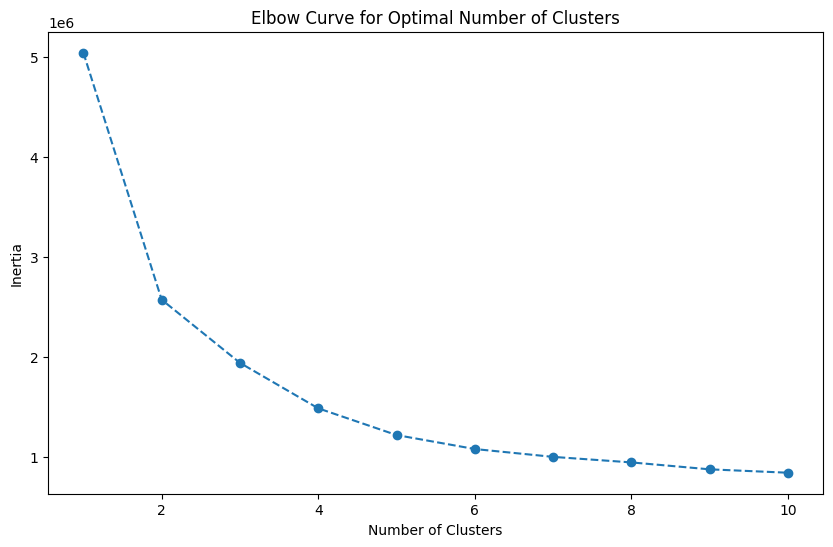

In [23]:

plot_elbow_curve(data)

Run below 2 cell (second one after unciting it) to visualize the cluster plots

In [24]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,1] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,1] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,1] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,1] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

In [25]:
"""plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)"""

"plt.style.use('ggplot')\n\nfor i in data.index.get_level_values('date').unique().tolist():\n    \n    g = data.xs(i, level=0)\n    \n    plt.title(f'Date {i}')\n    \n    plot_clusters(g)"

## Predifining centroids to group the stocks based on their RSI value.
### Keeping things simple here, we will be planning to optimize our portfolio based on the RSI Value

In [26]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [27]:
def get_clusters_with_specified_centroid(df, n_clusters=4):
    df['cluster'] = KMeans(n_clusters=n_clusters,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.drop('cluster', axis=1)

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters_with_specified_centroid)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       context_id                                                    
2002-01-31 A                  -0.006149  55.598069  2.854033  2.954090   
           AAPL               -0.007926  63.304255  0.268863  0.292884   
           ABT                -0.128915  61.997635  2.671156  2.703496   
           ADBE                0.000185  49.120168  2.861406  2.921234   
           ADI                -0.084558  49.626947  3.268712  3.359408   
...                                 ...        ...       ...       ...   
2024-10-31 VRTX                0.000091  56.061734  6.105670  6.147755   
           VZ                  0.000124  59.333021  3.778653  3.798940   
           WFC                 0.000307  68.482723  3.971998  4.056784   
           WMT                 0.000075  62.828637  4.374621  4.396177   
           XOM                 0.000156  55.106683  4.727822  4.791643   

                        bb_high       atr      macd  return_1m  return_2m  \
date       context_id                                                       
2002-01-31 A           3.054146 -0.009183 -0.046081   0.064539   0.054962   
           AAPL        0.316905 -1.229868 -0.184167   0.128769   0.077295   
           ABT         2.735837  2.463956  0.025361   0.038927   0.026204   
           ADBE        2.981063 -0.615679 -0.082874   0.085346   0.025145   
           ADI         3.450104  1.193607 -0.374254  -0.013291   0.015179   
...                         ...       ...       ...        ...        ...   
2024-10-31 VRTX        6.189840  2.189307  0.109836   0.039843  -0.012459   
           VZ          3.819226 -2.411993  0.812000  -0.006099   0.033615   
           WFC         4.141570 -2.166853  2.528969   0.120198   0.040319   
           WMT         4.417732 -2.112257  2.312886   0.010960   0.028123   
           XOM         4.855465 -2.073220  2.511397   0.033527   0.013517   

                       return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       context_id                                                          
2002-01-31 A            0.108697   0.009889  -0.027506   -0.047686  1.305325   
           AAPL         0.120749   0.046776  -0.003402    0.011209  1.471055   
           ABT          0.030163   0.013710   0.025947    0.022603  0.789230   
           ADBE         0.084927  -0.017458  -0.031299   -0.021268  1.217202   
           ADI          0.048488  -0.008135  -0.008529   -0.029322  1.117143   
...                          ...        ...        ...         ...       ...   
2024-10-31 VRTX        -0.008210   0.035266   0.012259    0.024404  0.883548   
           VZ           0.032775   0.023391   0.009475    0.024334  0.787923   
           WFC          0.024255   0.013079   0.028429    0.041997  0.929923   
           WMT          0.060503   0.051233   0.045809    0.035449  0.483092   
           XOM          0.009840   0.006717   0.021279    0.014223  1.097509   

                            SMB       HML       RMW       CMA  cluster  
date       context_id                                                   
2002-01-31 A           0.540264 -0.398558 -1.774975  1.974678        2  
           AAPL       -0.239981 -0.011345  0.498276 -1.657637        3  
           ABT        -0.340684 -0.313233 -0.000993  0.482566        3  
           ADBE       -0.044675 -0.432866 -0.398983 -0.564434        2  
           ADI        -0.862811  0.431471  0.214898 -2.322805        2  
...                         ...       ...       ...       ...      ...  
2024-10-31 VRTX       -0.207327 -1.345801 -2.650827 -2.038624        2  
           VZ         -0.498213 -0.316576  0.442654  1.077022        2  
           WFC        -0.251976  1.280999 -0.153532 -0.309163        3  
           WMT        -0.240292 -0.374322  0.515920  0.632053        3  
           XOM        -0.250757  0.410084  0.316642  0.450005        2  

[39269 rows x 19 columns]

## For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [28]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'context_id'])


In [29]:

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates 

{'2002-02-01': ['AAPL',
  'ABT',
  'AMZN',
  'BA',
  'BAX',
  'BKNG',
  'COST',
  'DLTR',
  'EMR',
  'FDX',
  'FITB',
  'GD',
  'HIG',
  'INTC',
  'IP',
  'ITW',
  'KLAC',
  'KMB',
  'LOW',
  'MCK',
  'MTCH',
  'NKE',
  'ORCL',
  'PEP',
  'PG',
  'RTX',
  'SBUX',
  'SLB',
  'TGT',
  'TJX',
  'TXN',
  'UNH',
  'UNP',
  'UPS',
  'WBA',
  'WFC',
  'WMT'],
 '2002-03-01': ['A',
  'ALL',
  'APA',
  'BA',
  'BAC',
  'CAT',
  'DE',
  'DVN',
  'FDX',
  'FITB',
  'GD',
  'HAL',
  'HES',
  'HIG',
  'HON',
  'IP',
  'ITW',
  'JNJ',
  'KMB',
  'KR',
  'LUV',
  'OMC',
  'PG',
  'RTX',
  'SBUX',
  'SLB',
  'UPS',
  'WBA',
  'WFC',
  'WMT',
  'XOM'],
 '2002-04-01': ['AFL',
  'ALL',
  'AMAT',
  'APA',
  'BAX',
  'CAH',
  'CCL',
  'CI',
  'COF',
  'COP',
  'CVS',
  'DGX',
  'DVN',
  'EOG',
  'HES',
  'IPG',
  'JNJ',
  'KO',
  'LH',
  'LRCX',
  'PG',
  'TER',
  'UNH',
  'UPS',
  'XOM'],
 '2002-05-01': ['AFL',
  'ALL',
  'AMZN',
  'APA',
  'BAC',
  'CCL',
  'CI',
  'DGX',
  'DLTR',
  'DVN',
  'EOG',
  'FI

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [30]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1), ## .1
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

* Download Fresh Daily Prices Data only for short listed stocks.

In [31]:
stocks = data.index.get_level_values('context_id').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  237 of 237 completed


Price                       Adj Close                                      \
Ticker                              A        AAPL        ABBV         ABT   
Date                                                                        
2001-01-31 00:00:00+00:00   32.929272    0.326103         NaN   10.865836   
2001-02-01 00:00:00+00:00   32.476540    0.318563         NaN   11.141959   
2001-02-02 00:00:00+00:00   31.510685    0.311024         NaN   11.023271   
2001-02-05 00:00:00+00:00   29.699736    0.304426         NaN   11.221891   
2001-02-06 00:00:00+00:00   30.768202    0.318563         NaN   11.425356   
...                               ...         ...         ...         ...   
2024-10-16 00:00:00+00:00  139.110001  231.779999  190.460007  117.820000   
2024-10-17 00:00:00+00:00  137.419998  232.149994  188.570007  117.889999   
2024-10-18 00:00:00+00:00  138.830002  235.000000  188.860001  119.389999   
2024-10-21 00:00:00+00:00  136.759995  236.479996  186.539993  116.989998   
2024-10-22 00:00:00+00:00  133.860001  235.812195  188.309998  116.050003   

Price                                                                     \
Ticker                            ACN        ADBE         ADI        ADM   
Date                                                                       
2001-01-31 00:00:00+00:00         NaN   21.707409   39.168121   8.423687   
2001-02-01 00:00:00+00:00         NaN   22.576950   37.040760   8.316483   
2001-02-02 00:00:00+00:00         NaN   21.645302   34.538010   8.638086   
2001-02-05 00:00:00+00:00         NaN   22.545893   33.693348   8.875051   
2001-02-06 00:00:00+00:00         NaN   21.862684   32.811115   8.451894   
...                               ...         ...         ...        ...   
2024-10-16 00:00:00+00:00  372.260010  502.540009  227.490005  58.290001   
2024-10-17 00:00:00+00:00  375.149994  496.829987  227.339996  58.630001   
2024-10-18 00:00:00+00:00  376.859985  494.899994  228.330002  56.400002   
2024-10-21 00:00:00+00:00  376.029999  497.709991  225.669998  56.130001   
2024-10-22 00:00:00+00:00  372.660004  494.190002  225.300003  56.029999   

Price                                              ...   Volume            \
Ticker                            ADP        ADSK  ...      WAT       WBA   
Date                                               ...                      
2001-01-31 00:00:00+00:00   28.348276    8.985422  ...   874500   2478100   
2001-02-01 00:00:00+00:00   28.272491    8.924501  ...  1044500   2762100   
2001-02-02 00:00:00+00:00   27.325329    8.574221  ...   472700   2653000   
2001-02-05 00:00:00+00:00   27.931517    8.787437  ...   783900   1977400   
2001-02-06 00:00:00+00:00   28.244081    9.000650  ...   554800   1970000   
...                               ...         ...  ...      ...       ...   
2024-10-16 00:00:00+00:00  290.700012  289.190002  ...   470200  49804600   
2024-10-17 00:00:00+00:00  291.959991  290.570007  ...   542600  32179900   
2024-10-18 00:00:00+00:00  292.290009  292.989990  ...   418800  21827300   
2024-10-21 00:00:00+00:00  290.910004  289.779999  ...   400800  19961900   
2024-10-22 00:00:00+00:00  291.420013  290.524994  ...   167942  24137031   

Price                                                                       \
Ticker                         WDC       WFC      WMB       WMT       WYNN   
Date                                                                         
2001-01-31 00:00:00+00:00  4315900   6828200  2282744  32544300        NaN   
2001-02-01 00:00:00+00:00  1367000   9373200  2073752  31155900        NaN   
2001-02-02 00:00:00+00:00  1390700   5189000  1989701  15195000        NaN   
2001-02-05 00:00:00+00:00   755800   5201000  3627830  16812600        NaN   
2001-02-06 00:00:00+00:00   671100   5214800  2552938  16182000        NaN   
...                            ...       ...      ...       ...        ...   
2024-10-16 00:00:00+00:00  4441500  17412600  6041000  11123300  1697700.0 

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

In [32]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        #optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        optimization_df = new_df['Adj Close'][cols][optimization_start_date:optimization_end_date]
        #display(optimization_df)
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
          
            weights = pd.DataFrame(weights, index=pd.Series(0))
            #print(weights)
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:

            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        
        #display(weights.stack().to_frame('weight').reset_index(level=0, drop=True))
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
                 
        
        #display(temp_df)
        #break

        temp_df.index.names = ['date', 'ticker']
        

        temp_df['weights'] = temp_df['weight']

#        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2002-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2002-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2002-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2003-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2003-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2006-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2007-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-12-01, Continuing with Equal-Weights

return   weight  weights
date                      ticker                            
2002-02-01 00:00:00+00:00 AAPL   -0.012621  0.01400  0.01400
                          ABT    -0.004516  0.09999  0.09999
                          AMZN   -0.032954  0.01400  0.01400
                          BA      0.012377  0.01400  0.01400
                          BAX    -0.005928  0.10000  0.10000
...                                    ...      ...      ...
2024-10-22 00:00:00+00:00 TSLA   -0.004900  0.01099  0.01099
                          UAL     0.009013  0.01099  0.01099
                          UPS     0.005392  0.01100  0.01100
                          VZ     -0.049842  0.01100  0.01100
                          WMT     0.015106  0.09132  0.09132

[160745 rows x 3 columns]

## Visualizing Optimized Portfolio with Stocks along with their weights

In [37]:
def get_month_date_range():
    
    user_input = input("Enter the month and year (e.g., September-2024): ")
    
    try:
        user_month_year = pd.to_datetime(user_input, format='%B-%Y')
    except ValueError:
        print("Invalid format! Please use the format 'Month-Year'.")
        return None, None

    start_date = user_month_year.replace(day=1)
    end_date = start_date + relativedelta(months=1) - pd.DateOffset(days=1)

    return start_date, end_date

start_date, end_date = get_month_date_range()

if start_date and end_date:
    portfolio_df.index = portfolio_df.index.set_levels([pd.to_datetime(portfolio_df.index.levels[0]).tz_localize(None), 
                                                        portfolio_df.index.levels[1]])

    month_data = portfolio_df.loc[(portfolio_df.index.get_level_values('date') >= start_date) & 
                                  (portfolio_df.index.get_level_values('date') <= end_date)]

    optimized_stocks_df = month_data[['weight']].reset_index().drop_duplicates(subset='ticker')

    optimized_stocks_df = optimized_stocks_df.groupby('ticker', as_index=False)['weight'].mean()

    optimized_stocks_df.title = f"Optimized stocks for {start_date.strftime('%B-%Y')}"

    print(f"\nOptimized stocks for {start_date.strftime('%B-%Y')}:")
    display(optimized_stocks_df)
else:
    print("Could not generate results due to invalid date input.")



Optimized stocks for September-2024:


,ticker,weight
0,ABBV,0.01400
1,ACN,0.01400
2,ADP,0.01400
3,BLK,0.01400
4,BRK-B,0.01400
5,BSX,0.10000
6,CI,0.01400
7,FI,0.01400
8,FIS,0.01400
9,GILD,0.01400


In [38]:
from flask import Flask, request, jsonify
import pandas as pd
from dateutil.relativedelta import relativedelta

app = Flask(__name__)

def get_month_date_range(user_input):
    try:
        user_month_year = pd.to_datetime(user_input, format='%B-%Y')
    except ValueError:
        return None, None, "Invalid format! Please use 'Month-Year'."
    
    start_date = user_month_year.replace(day=1)
    end_date = start_date + relativedelta(months=1) - pd.DateOffset(days=1)
    
    return start_date, end_date, None

@app.route('/', methods=['GET'])
def welcome():
    return "Welcome to Optimization"

@app.route('/get_optimized_portfolio', methods=['POST'])
def get_optimized_portfolio():
    try:
        data = request.json
        user_input = data.get('date')

        start_date, end_date, error = get_month_date_range(user_input)
        
        if error:
            return jsonify({"error": error}), 400

        portfolio_df.index = portfolio_df.index.set_levels([
            pd.to_datetime(portfolio_df.index.levels[0]).tz_localize(None),
            portfolio_df.index.levels[1]
        ])
        
        month_data = portfolio_df.loc[(portfolio_df.index.get_level_values('date') >= start_date) & 
                                      (portfolio_df.index.get_level_values('date') <= end_date)]

        optimized_stocks_df = month_data[['weight']].reset_index().drop_duplicates(subset='ticker')
        optimized_stocks_df = optimized_stocks_df.groupby('ticker', as_index=False)['weight'].mean()

        result = optimized_stocks_df.to_dict(orient='records')
        
        return jsonify({"optimized_stocks": result, "title": f"Optimized stocks for {start_date.strftime('%B-%Y')}"})

    except Exception as e:
        return jsonify({"error": str(e)}), 500

def run_flask():
    app.run(host='0.0.0.0', port=5000)




In [39]:
# Start the Flask app in a separate thread
import threading
flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True 
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.230.152:5000
Press CTRL+C to quit
